# Policy Gradient Methods

In this notebook we will solve the Cartpole balancing problem using the **Policy Gradient Method REINFORCE**.<br>

In particular we will use a neural network to approximate our policy $\pi(a|s)$. To that end we will rely on an auto-differentiation framework which will provide us with the gradients of our policy with respect to its parameters.

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import testing

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
from torch.nn.init import calculate_gain

from typing import Union, Tuple


### A helper function to convert seeds from a seed sequence to python `int`s:

In [2]:
def seed_adapter(seed_sequence: np.random.SeedSequence) -> int:
    # spawn a new child generator from the seed_sequence
    child = seed_sequence.spawn(1)[0]

    # generate a random seed
    seed_uint64 = child.generate_state(1, np.uint64)[0]

    # torch and the numpy PRNGs used in the openai gym want a python 'int', not a 'numpy.uint64'!
    seed_int = int(seed_uint64)

    print('seed_int', seed_int)
    return seed_int

### Some helper functions to initialize the weights of neural networks:

In [3]:
def relu_init(m: torch.nn.Linear) -> None:
    # print('relu_init', m)
    nn.init.kaiming_normal_(
        m.weight.data, 0.,
        mode='fan_in',
        nonlinearity='relu'
    )
    nn.init.constant_(m.bias.data, 0.)


def linear_init(m: torch.nn.Linear) -> None:
    # print('linear_init', m)
    nn.init.kaiming_normal_(
        m.weight.data, 0.,
        mode='fan_in',
        nonlinearity='linear'
    )
    nn.init.constant_(m.bias.data, 0.)


def softmax_init(m: torch.nn.Linear) -> None:
    # print('softmax_init', m)
    nn.init.xavier_normal_(m.weight.data, calculate_gain('sigmoid'))
    nn.init.constant_(m.bias.data, 0.)

### Neural network definitions for a policy $\pi_{\Theta}(a | s)$, and a state value function $V_{\Phi}(s)$:

In [4]:
class PolicyNet(nn.Module):
    def __init__(self, n_in: int, n_out: int) -> None:
        super(PolicyNet, self).__init__()
        n_hidden = 128
        self.net = nn.Sequential(
            nn.Linear(n_in, n_hidden),
            nn.ReLU(inplace=False),
            nn.Linear(n_hidden, n_out),
            nn.Softmax(dim=1)
        )
        relu_init(self.net[0])
        softmax_init(self.net[2])

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


class ValueNet(nn.Module):
    def __init__(self, n_in: int, n_out: int) -> None:
        super(ValueNet, self).__init__()
        n_hidden = 128
        self.net = nn.Sequential(
            nn.Linear(n_in, n_hidden),
            nn.ReLU(inplace=False),
            nn.Linear(n_hidden, n_out),
        )
        relu_init(self.net[0])
        linear_init(self.net[2])

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

### Helper function to compute (standardized) returns:

In [5]:
def compute_returns(rewards: torch.Tensor, gamma: float) -> list[float]:
    returns = []
    G = 0
    for r in rewards[::-1]:
        G = r + gamma * G
        returns.insert(0, G)
    
    # this is a trick that is often used, when we
    # use function approximators to learn values
    # or policies: the returns are standardized to
    # have a mean value of 0, and a stddev of 1.
    # this has a stabilizing effect on training.
    returns = np.array(returns)
    returns = returns - returns.mean()
    returns = returns / returns.std()
    return returns

### A helper function that visualizes an episode:
We'll see after the definition of agent, how to use this.

In [6]:
def visualize_episode(gamma: float, episode: dict, losses: dict=dict()) -> None:
    states = np.array(episode['states'])
    actions = np.array(episode['actions'])
    rewards = np.array(episode['rewards'])
    
    if 'values' in episode:
        values = torch.cat(episode['values']).squeeze().detach().numpy()
    else:
        values = np.full_like(rewards, np.nan, dtype=float)

    if len(losses) > 0 and 'policy_losses' in losses:
        p_losses = losses['policy_losses'].detach().numpy()
    else:
        p_losses = np.full_like(rewards, np.nan, dtype=float)
        
    if len(losses) > 0 and 'value_losses' in losses:
        v_losses = losses['value_losses'].detach().numpy()
    else:
        v_losses = np.full_like(rewards, np.nan, dtype=float)

    returns = compute_returns(episode['rewards'], gamma)

    deltas = returns - values
    linestyle = '-'

    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 6), sharex=True)
    ax = axes[0, 0]
    ax.set_title('states')
    ax.plot(states[:, 0], linestyle=linestyle, marker='.', label='cart position')
    ax.plot(states[:, 1], linestyle=linestyle, marker='.', label='cart velocity')
    ax.plot(states[:, 2], linestyle=linestyle, marker='.', label='pole angle')
    ax.plot(states[:, 3], linestyle=linestyle, marker='.', label='pole angular velocity')
    ax.legend()
    

    ax = axes[0, 1]
    ax.set_title('actions (from policy net)')
    ax.set_yticks([0, 1])
    ax.set_yticklabels(['left', 'right'])
    ax.set_ylim([-0.1, 1.1])
    ax.plot(actions, linestyle=' ', marker='.')

    ax = axes[1, 0]
    ax.set_title('rewards')
    ax.set_yticks([0, 1])
    ax.set_ylim([-0.1, 1.1])
    ax.plot(rewards, linestyle=linestyle, marker='.')

    ax = axes[1, 1]
    ax.set_title('values vs. returns')
    ax.plot(values, linestyle=linestyle, marker='.', label='values')
    ax.plot(returns, linestyle=linestyle, marker='x', label='returns')
    ax.legend()

    ax = axes[2, 0]
    ax.set_title('policy & value losses')
    ax.plot(p_losses, linestyle=linestyle, marker='.', label='policy loss')
    ax.plot(v_losses, linestyle=linestyle, marker='.', label='value loss')
    ax.legend()

    ax = axes[2, 1]
    ax.set_title('deltas (returns - values)')
    ax.plot(deltas, linestyle=linestyle, marker='.')

    for ax in axes.flatten():
        h = len(states) // 2
        m = len(states)
        ax.set_xticks([0, h, m])

    # all axes in the bottom row
    for ax in axes[-1, :].flatten():
        ax.set_xlabel('timestep t')
    plt.tight_layout()
    plt.show()

## The class definition of the REINFORCE agent
This is a partial definition of an RL agent that is supposed to implement the REINFORCE algorithm. You will implement the agent step-by-step. Look at the TODOs, and the later cells, and follow each step. At the end of each step, you should have a fully functional agent, that is able to learn to balance a pole on a cart.

In [7]:
class REINFORCEAgent():
    def __init__(self, env: gym.Env, alpha: float):
        self.n_actions = env.action_space.n
        self.n_observation = list(env.observation_space.shape)[0]

        self.policy = PolicyNet(self.n_observation, self.n_actions)
        self.optimizer = optim.Adam(
            self.policy.parameters(),
            lr=alpha,
        )
        
    def get_action_and_log_prob(self, state: int) -> Tuple[int, float]:
        pass

    def generate_episode(self, env: gym.Env) -> dict:
        pass

    def update(self, episode: dict, gamma: float) -> None:
        pass

## (1) Implement action selection 
The first thing you will need to do is to implement action selection with a <b>parametrized policy</b>. 


In [8]:
def get_action_and_log_prob(self, state: int) -> Tuple[int, torch.Tensor]:
    """
    Samples a single action from the policy net.
    
    Args:
        state: the state to sample the action for
    
    Returns:
        a tuple containing the sampled action and the log probability of the selected action
    """
    # get the state as a pytorch tensor, bring it into the right format
    state = torch.from_numpy(state).float().unsqueeze(0)

    # use the policy network to get the distribution pi(a | s), and
    prob_action = self.policy(state)
    action_categorical = Categorical(prob_action)
    
    # return both the sampled action, and its log probability
    action = action_categorical.sample()
    log_prob_of_action = action_categorical.log_prob(action)
    
    return action.item(), log_prob_of_action

REINFORCEAgent.get_action_and_log_prob = get_action_and_log_prob

In [9]:
gamma = 0.99
seed_sequence = np.random.SeedSequence(1)

env = gym.make('CartPole-v1')

env.seed(seed_adapter(seed_sequence))
torch.manual_seed(seed_adapter(seed_sequence))

agent = REINFORCEAgent(env, alpha=1e-3)

# let's get the starting state of the environment
state = env.reset()

# now we'll test the action selection method
action, log_prob = agent.get_action_and_log_prob(state)

# this should be an integer
print('action:', action, type(action))

# and this should be a torch tensor with a 'grad_fn' field
print('log_prob:', log_prob, type(log_prob))

assert testing.is_type(action, int)
assert testing.is_type(log_prob, torch.Tensor)
assert log_prob.shape == (1,), "Remove the empty dimensions!"


seed_int 8431846347943309920
seed_int 4042681867674859579
action: 0 <class 'int'>
log_prob: tensor([-0.7008], grad_fn=<SqueezeBackward1>) <class 'torch.Tensor'>


## (2) Implement episode generation 
Now that we can select an action, given a state, let's see if we can generate an episode.

In [10]:
def generate_episode(self, env: gym.Env) -> dict:
    """
    Gernerates a single episode.
    
    Args:
        env: the openai gym environment
    
    Returns:
        a dicitonary with states, actions, rewards, and log probabilites
    """
    states = []
    actions = []
    log_probs = []
    rewards = []

    done = False
    state = env.reset()
      

    # need to return:
    # - a list of states (including S_0, excluding terminal state)
    # - a list of actions
    # - a list of the log probabilities of the actions
    # - a list of rewards

    while not done:
        action, log_prob = self.get_action_and_log_prob(state)
        next_state, reward, done, _ = env.step(action)

        states.append(state)
        actions.append(action)
        log_probs.append(log_prob)
        rewards.append(reward)

        state = next_state

    return dict(
        states=states,
        actions=actions,
        rewards=rewards,
        log_probs=log_probs
    )

REINFORCEAgent.generate_episode = generate_episode

seed_int 3890642289391122579
seed_int 13194552230369835111


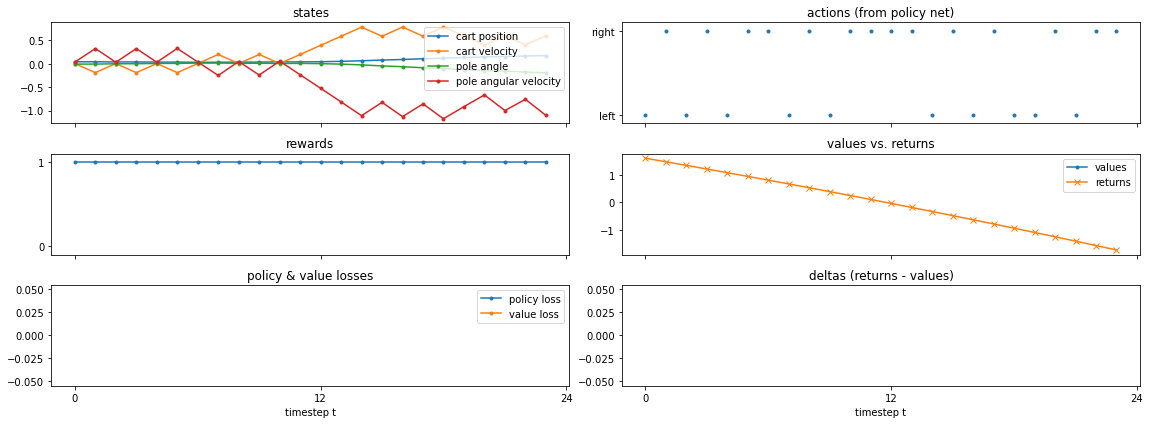

In [11]:
gamma = 0.99
seed_sequence = np.random.SeedSequence(2)

env = gym.make('CartPole-v1')

env.seed(seed_adapter(seed_sequence))
torch.manual_seed(seed_adapter(seed_sequence))

agent = REINFORCEAgent(env, alpha=1e-3)
episode = agent.generate_episode(env)

assert testing.is_type(episode['states'], list)
assert testing.is_type(episode['rewards'], list)
assert testing.is_type(episode['log_probs'], list)
assert testing.is_type(episode['actions'], list)

assert [testing.is_type(s, np.ndarray) for s in episode['states']]
assert [testing.is_type(s, float) for s in episode['rewards']]
assert [testing.is_type(s, torch.Tensor) for s in episode['log_probs']]
assert [testing.is_type(s, int) for s in episode['actions']]

visualize_episode(gamma, episode)

## (3) Implement the REINFORCE update
Now that we made sure we can generate an episode, your next task is to implement the REINFORCE update. 

In [12]:
def update(self, episode: dict, gamma: float) -> dict:
    """
    Updates the policy network and returns a dictionary with the overall loss and the loss at each step  
    
    Args:
        episode: a dicitonary with states, actions, rewards, and log probabilites
        gamma: the discount factor
    
    Returns:
        a dicitonary with the loss at each state and the overall loss
    """   
    # track of the loss terms at the individual steps
    policy_losses = []
    
    # returns
    returns = compute_returns(episode['rewards'], gamma)
    # loop through the episode, compute the loss terms for the individual steps
    for index,step in enumerate(episode['actions']):
        loss = - (gamma ** index) * returns[index] * episode['log_probs'][index]
        policy_losses.append(loss)
    

    # this resets the gradients on all involved weight tensors
    self.optimizer.zero_grad()

    # this concatenates all individual policy loss terms
    policy_losses = torch.cat(policy_losses)
        
    # here we sum all policy losses up. this implements the gradient accumulation
    policy_loss = policy_losses.sum()

    # this computes the gradient of the loss wrt all involved weight tensors
    policy_loss.backward()

    #update of the weights
    self.optimizer.step()
        
    # finally, we'll return the policy_loss for visualization purposes later on
    return dict(
        policy_loss=policy_loss.item(),
        policy_losses=policy_losses
    )

REINFORCEAgent.update = update

seed_int 14449357594836781232
seed_int 18443715169928553612


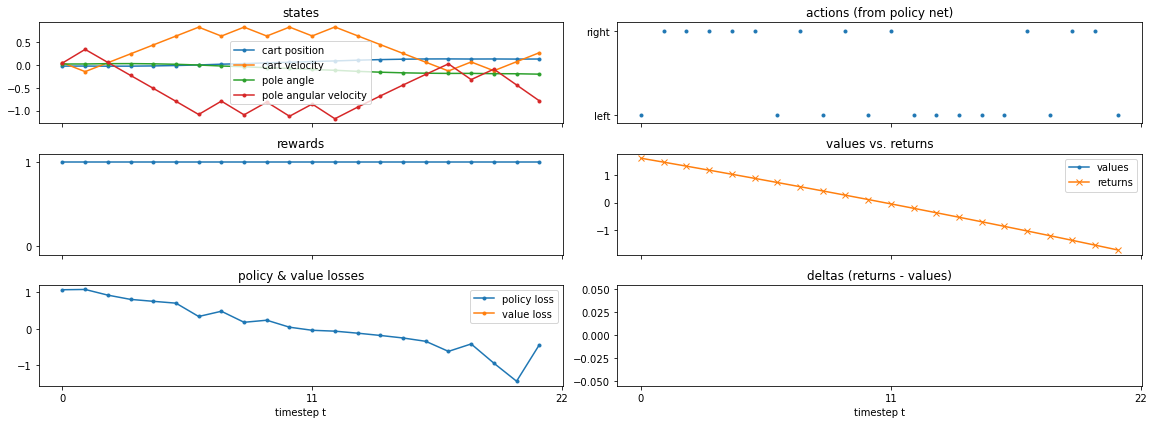

In [13]:
gamma = 0.99
seed_sequence = np.random.SeedSequence(3)

env = gym.make('CartPole-v1')

env.seed(seed_adapter(seed_sequence))
torch.manual_seed(seed_adapter(seed_sequence))

agent = REINFORCEAgent(env, alpha=1e-3)
episode = agent.generate_episode(env)

assert testing.is_type(episode['states'], list)
assert testing.is_type(episode['rewards'], list)
assert testing.is_type(episode['log_probs'], list)
assert testing.is_type(episode['actions'], list)

assert [testing.is_type(s, np.ndarray) for s in episode['states']]
assert [testing.is_type(s, float) for s in episode['rewards']]
assert [testing.is_type(s, torch.Tensor) for s in episode['log_probs']]
assert [testing.is_type(s, int) for s in episode['actions']]

losses = agent.update(episode, gamma)

assert testing.is_type(losses['policy_loss'], float)
assert testing.is_type(losses['policy_losses'], torch.Tensor)

visualize_episode(gamma, episode, losses)

### Making sure REINFORCE learns something useful

seed_int 16363712187084821697
seed_int 7001527192274380292


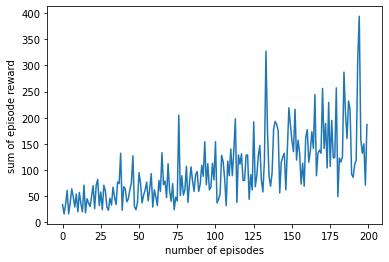

In [14]:
gamma = 0.99
seed_sequence = np.random.SeedSequence(4)

env = gym.make('CartPole-v1')
env.seed(seed_adapter(seed_sequence))

torch.manual_seed(seed_adapter(seed_sequence))
agent = REINFORCEAgent(env, alpha=1e-3)

episode_rewards = []
for i_episode in range(200):
    episode = agent.generate_episode(env)
    losses = agent.update(episode, gamma)
    episode_rewards.append(np.sum(episode['rewards']))

fig, ax = plt.subplots()
ax.set_ylabel('sum of episode reward')
ax.set_xlabel('number of episodes')
ax.plot(episode_rewards)
plt.show()

### Let's look at a generated episode, after the agent has trained for 200 episodes:

seed_int 14449357594836781232
seed_int 18443715169928553612


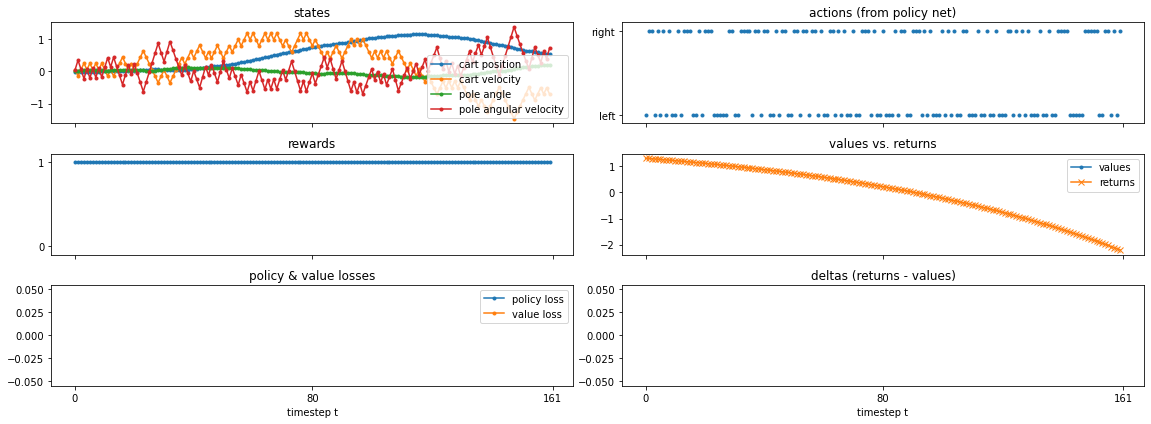

In [15]:
seed_sequence = np.random.SeedSequence(3)

env = gym.make('CartPole-v1')
env.seed(seed_adapter(seed_sequence))

# this needs to be set before generating an episode, as it governs the sampling happening in the `Categorical` distribution
torch.manual_seed(seed_adapter(seed_sequence))
episode = agent.generate_episode(env)
visualize_episode(gamma, episode)

## (4) Computational experiments with REINFORCE 

In [16]:
# a helper function that runs computational experiments
def run_experiments(seed_sequence,
                    env,
                    gamma,
                    n_runs,
                    n_episodes,
                    agent_class,
                    agent_params,
                    log_interval=50):
    print('-' * 60)
    print('agent_class', agent_class)
    print('agent_params', agent_params)
    env.seed(seed_adapter(seed_sequence))
    torch.manual_seed(seed_adapter(seed_sequence))

    import sys
    run_rewards = []
    for i_run in range(n_runs):
        # at the start of each run, we instantiate a new agent
        agent = agent_class(**agent_params)
        episode_rewards = []
        for i_episode in range(n_episodes):
            episode = agent.generate_episode(env)
            losses = agent.update(episode, gamma)
            episode_rewards.append(np.sum(episode['rewards']))
            
            # "make sure we can watch optimizer TV", i.e. display progress, and
            # do some fancy logging, so that we have the feeling that something
            # is happening, while we are waiting ... :)
            if i_episode % log_interval == 0 or i_episode == n_episodes - 1:
                out = f'run:{i_run}/{n_runs} ep:{i_episode:>04d}/{n_episodes} '
                for name, value in losses.items():
                    if name.endswith('_loss'):
                        out += f'{name}:{value:04.2f} '
                out += f'avg reward last 10 episodes:{np.mean(episode_rewards[-10:])}'
                
                # overwrite what's already been written
                sys.stdout.write('\r' + ' ' * 400)
                # write 'out' to stdout
                sys.stdout.write(f'\r{out}')
                sys.stdout.flush()

        run_rewards.append(episode_rewards)
    print()
    # this returns an array with the sum of rewards for each episode.
    # it is shaped like this: (n_runs, n_episodes)
    return np.array(run_rewards)

# a helper function for plotting later on
def plot(ax, rewards, label):
    mean_rewards = np.mean(rewards, axis=0)
    std_rewards = np.std(rewards, axis=0)
    ax.fill_between(
        np.arange(rewards.shape[1]),
        np.maximum(1, mean_rewards - std_rewards),    # sums smaller than 1 are impossible
        np.minimum(500, mean_rewards + std_rewards),  # sums larger than 500 are impossible
        alpha=0.4  # this specifies transparency of the area that's filled in
    )
    ax.plot(mean_rewards, label=label)

### Run three experiments
Run three computational experiments, each with a different learning rate `alpha`. 

In [17]:
gamma = 0.99
seed_sequence = np.random.SeedSequence(5)

env = gym.make('CartPole-v1')

n_runs = 5
n_episodes = 200
alphas = [1e-4, 1e-3, 1e-2]

#Experiments
run_rewards = dict()
for alpha in alphas:
    run_rewards[alpha] = run_experiments(seed_sequence = seed_sequence,env = env,gamma = gamma,n_runs = n_runs,n_episodes = n_episodes,agent_class = REINFORCEAgent,agent_params = {'env':env, 'alpha':alpha},log_interval=50)


------------------------------------------------------------
agent_class <class '__main__.REINFORCEAgent'>
agent_params {'env': <TimeLimit<CartPoleEnv<CartPole-v1>>>, 'alpha': 0.0001}
seed_int 15658875773272509128
seed_int 6924645418555453511
run:4/5 ep:0199/200 policy_loss:0.34 avg reward last 10 episodes:16.1                                                                                                                                                                                                                                                                                                                                           
------------------------------------------------------------
agent_class <class '__main__.REINFORCEAgent'>
agent_params {'env': <TimeLimit<CartPoleEnv<CartPole-v1>>>, 'alpha': 0.001}
seed_int 1725439304048894018
seed_int 13230002727910310950
run:4/5 ep:0199/200 policy_loss:23.19 avg reward last 10 episodes:113.6                                           

In [18]:
assert all([testing.is_type(run_rewards[a], np.ndarray) for a in alphas])
assert all([run_rewards[a].shape == (n_runs, n_episodes) for a in alphas])

### Plot the outcomes of the three experiments

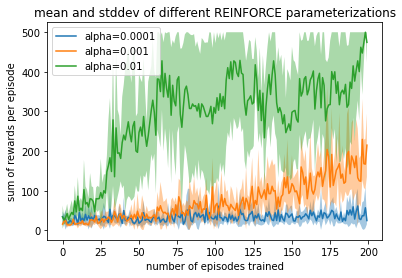

In [19]:
fig, ax = plt.subplots()
ax.set_title('mean and stddev of different REINFORCE parameterizations')
ax.set_ylabel('sum of rewards per episode')
ax.set_xlabel('number of episodes trained')
for alpha, rewards in run_rewards.items():
    plot(ax, rewards, label=f'alpha={alpha}')
ax.legend()
plt.show()

## The class definition of the REINFORCE agent with Baseline
Here we will need to add a baseline to the REINFORCE agent.

In [20]:
class REINFORCE_BL_Agent():
    def __init__(self, env, policy_alpha, value_alpha):
        # this agent provides the option of optimizing
        # the policy net and the value net with different learning rates
        self.n_actions = env.action_space.n
        self.n_observation = list(env.observation_space.shape)[0]

        self.policy = PolicyNet(self.n_observation, self.n_actions)
        self.policy_optimizer = optim.Adam(
            self.policy.parameters(),
            lr=policy_alpha
        )

        self.value = ValueNet(self.n_observation, 1)
        self.value_optimizer = optim.Adam(
            self.value.parameters(),
            lr=value_alpha
        )

    def get_action_and_log_prob(self, state: int) -> Tuple[int, float]:
        pass

    def get_value(self, state: int):
        pass

    def generate_episode(self, env: gym.Env) -> dict:
        pass

    def update(self, episode: dict, gamma: float) -> None:
        pass
    
# we can reuse this one from above
REINFORCE_BL_Agent.get_action_and_log_prob = REINFORCEAgent.get_action_and_log_prob

## (5) Implement get_value 

In [21]:
def get_value(self, state: int) -> torch.Tensor:
    """
    Evaluates the value net on the state that is passed in.
    
    Args:
        state: the state to sample the action for
    
    Returns:
        the value estimate
    """
    state = torch.from_numpy(state).float()
    value = self.value(state)
    return value

REINFORCE_BL_Agent.get_value = get_value

In [22]:
gamma = 0.99
seed_sequence = np.random.SeedSequence(1)

env = gym.make('CartPole-v1')

env.seed(seed_adapter(seed_sequence))
torch.manual_seed(seed_adapter(seed_sequence))

agent = REINFORCE_BL_Agent(env, policy_alpha=1e-3, value_alpha=1e-3)

# let's get the starting state of the environment
state = env.reset()

# now we'll test the action selection method
action, log_prob = agent.get_action_and_log_prob(state)

# now we'll get the value
value = agent.get_value(state)

assert testing.is_type(value, torch.Tensor)
assert value.shape == (1,), "Remove the empty batch dimension!"


seed_int 8431846347943309920
seed_int 4042681867674859579


## (6) Implement generate_episode for REINFORCE with baseline

In [23]:
def generate_episode(self, env: gym.Env) -> dict:
    """
    Gernerates a single episode and records the values for each state.
    
    Args:
        env: the openai gym environment
    
    Returns:
        a dicitonary with states, actions, rewards, the values and log probabilites
    """
    states = []
    actions = []
    log_probs = []
    rewards = []
    values = []

    done = False
    state = env.reset()
      
    #return:
    # - a list of states (including S_0, excluding terminal state)
    # - a list of actions
    # - a list of the log probabilities of the actions
    # - a list of rewards
    # - a list of values
    
    # YOUR CODE HERE
    while not done:
        action, log_prob = self.get_action_and_log_prob(state)
        next_state, reward, done, _ = env.step(action)

        states.append(state)
        actions.append(action)
        log_probs.append(log_prob)
        rewards.append(reward)
        values.append(self.get_value(state))

        state = next_state

    return dict(
        states=states,
        actions=actions,
        rewards=rewards,
        log_probs=log_probs,
        values=values
    )

REINFORCE_BL_Agent.generate_episode = generate_episode

In [24]:
gamma = 0.99
seed_sequence = np.random.SeedSequence(2)

env = gym.make('CartPole-v1')

env.seed(seed_adapter(seed_sequence))
torch.manual_seed(seed_adapter(seed_sequence))

agent = REINFORCE_BL_Agent(env, policy_alpha=1e-3, value_alpha=1e-3)
episode = agent.generate_episode(env)

assert testing.is_type(episode['states'], list)
assert testing.is_type(episode['rewards'], list)
assert testing.is_type(episode['log_probs'], list)
assert testing.is_type(episode['actions'], list)
assert testing.is_type(episode['values'], list)

assert [testing.is_type(s, np.ndarray) for s in episode['states']]
assert [testing.is_type(s, float) for s in episode['rewards']]
assert [testing.is_type(s, torch.Tensor) for s in episode['log_probs']]
assert [testing.is_type(s, int) for s in episode['actions']]
assert [testing.is_type(s, torch.Tensor) for s in episode['values']]


seed_int 3890642289391122579
seed_int 13194552230369835111


## (7) Implement update for REINFORCE with baseline 


In [25]:
def update(self, episode: dict, gamma: float) -> dict:
    """
    Updates the policy and value networks and returns 
    a dictionary with the overall loss and the loss at 
    each step for the policy and value nets.
    
    Args:
        episode: a dicitonary with states, actions, rewards, and log probabilites
        gamma: the discount factor
    
    Returns:
        a dicitonary with the loss at each state and the overall loss for the policy and value nets.
    """   
    # use this list to keep track of the loss terms at the individual steps
    policy_losses = []
    value_losses = []
    
    # returns
    returns = compute_returns(episode['rewards'], gamma)

    
    
    deltas = returns - torch.cat(episode['values']).detach().numpy()

    # loop through the episode, compute the loss terms for the individual steps
    for index,step in enumerate(episode['actions']):
                
        value_loss =  (returns[index]- episode['values'][index]) ** 2
        value_losses.append(value_loss)

        policy_loss =  - (gamma ** index) * deltas[index] * episode['log_probs'][index]
        policy_losses.append(policy_loss)
    
    # this resets the gradients on all involved weight tensors
    self.policy_optimizer.zero_grad()
    self.value_optimizer.zero_grad()
    
    # this concatenates all individual policy loss terms
    policy_losses = torch.cat(policy_losses)
    value_losses = torch.cat(value_losses)
        
    #losses
    policy_loss = policy_losses.sum()
    value_loss = value_losses.sum()

    #Gradients
    policy_loss.backward()
    value_loss.backward()
    
    # update of the weights
    self.policy_optimizer.step()
    self.value_optimizer.step()
        
    # finally, we'll return the policy_loss and value_loss for visualization purposes later on
    return dict(
        policy_loss=policy_loss.item(),
        value_loss=value_loss.item(),
        policy_losses=policy_losses,
        value_losses=value_losses
    )

REINFORCE_BL_Agent.update = update

In [26]:
gamma = 0.99
seed_sequence = np.random.SeedSequence(3)

env = gym.make('CartPole-v1')

env.seed(seed_adapter(seed_sequence))
torch.manual_seed(seed_adapter(seed_sequence))

agent = REINFORCE_BL_Agent(env, policy_alpha=1e-3, value_alpha=1e-3)
episode = agent.generate_episode(env)

assert testing.is_type(episode['states'], list)
assert testing.is_type(episode['rewards'], list)
assert testing.is_type(episode['log_probs'], list)
assert testing.is_type(episode['actions'], list)

assert [testing.is_type(s, np.ndarray) for s in episode['states']]
assert [testing.is_type(s, float) for s in episode['rewards']]
assert [testing.is_type(s, torch.Tensor) for s in episode['log_probs']]
assert [testing.is_type(s, int) for s in episode['actions']]
assert [testing.is_type(s, torch.Tensor) for s in episode['values']]

losses = agent.update(episode, gamma)

assert testing.is_type(losses['policy_loss'], float)
assert testing.is_type(losses['policy_losses'], torch.Tensor)
assert testing.is_type(losses['value_loss'], float)
assert testing.is_type(losses['value_losses'], torch.Tensor)

assert losses['policy_losses'].shape == (12,), "Remove empty dimensions!"
assert losses['value_losses'].shape == (12,), "Remove empty dimensions!"


seed_int 14449357594836781232
seed_int 18443715169928553612


### Checking that you got the REINFORCE with baseline update correct

seed_int 10324823579957477319
seed_int 2479505222830176779


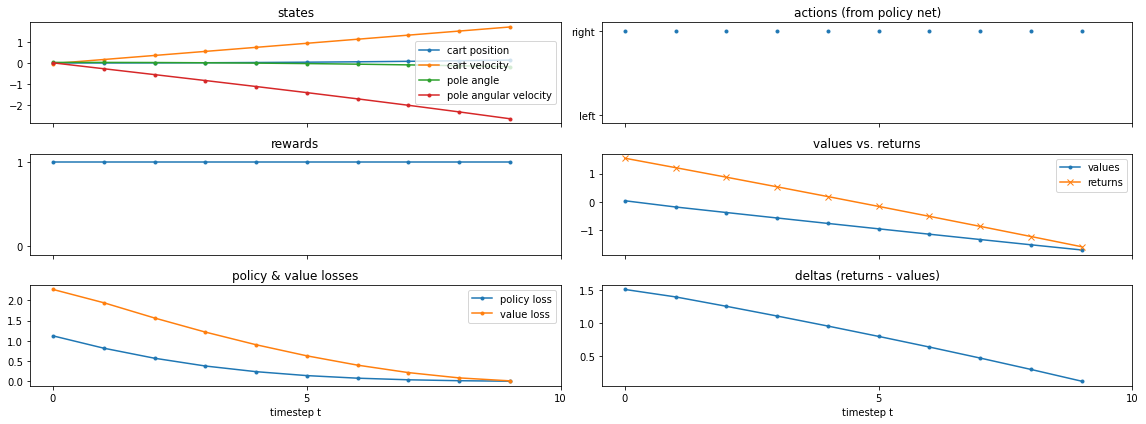

In [27]:
gamma = 0.99
seed_sequence = np.random.SeedSequence(6)

env = gym.make('CartPole-v1')

env.seed(seed_adapter(seed_sequence))
torch.manual_seed(seed_adapter(seed_sequence))

agent = REINFORCE_BL_Agent(env, policy_alpha=1e-3, value_alpha=1e-3)
episode = agent.generate_episode(env)
losses = agent.update(episode, gamma)
visualize_episode(gamma, episode, losses)


### Making sure REINFORCE with baseline learns something useful
Let's train the REINFORCE with baseline agent for 200 episodes, and see what it has learned.

seed_int 3386250816931739734
seed_int 4042502035264064771


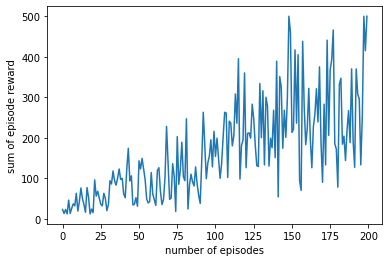

In [28]:
gamma = 0.99
seed_sequence = np.random.SeedSequence(7)

env = gym.make('CartPole-v1')
env.seed(seed_adapter(seed_sequence))

torch.manual_seed(seed_adapter(seed_sequence))
agent = REINFORCE_BL_Agent(env, policy_alpha=1e-3, value_alpha=1e-3)

episode_rewards = []
for i_episode in range(200):
    episode = agent.generate_episode(env)
    losses = agent.update(episode, gamma)
    episode_rewards.append(np.sum(episode['rewards']))

fig, ax = plt.subplots()
ax.set_ylabel('sum of episode reward')
ax.set_xlabel('number of episodes')
ax.plot(episode_rewards)
plt.show()

### Let's look at a generated episode, after the agent has trained for 200 episodes:


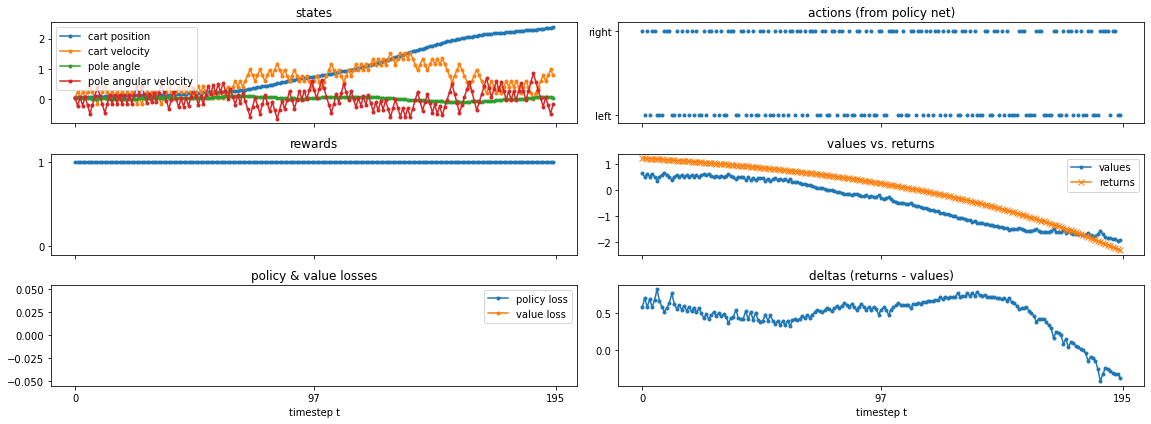

In [29]:
seed_sequence = np.random.SeedSequence(20211208)

env = gym.make('CartPole-v1')

episode = agent.generate_episode(env)
visualize_episode(gamma, episode)

## (8) Run a comparison between REINFORCE and REINFORCE with Baseline 
Perfomance comparison of REINFORCE and REINFORCE with Baseline. Each algorithm needs to be run 7 times, for 500 episodes. All learn rates should be the `alpha` value given below, including `policy_alpha` and `value_alpha` for REINFORCE with Baseline.

In [30]:
gamma = 0.99
seed_sequence = np.random.SeedSequence(7)

env = gym.make('CartPole-v1')

n_runs = 7
n_episodes = 500
alpha = 1e-2

reinforce_rewards = run_experiments(seed_sequence = seed_sequence,env = env,gamma = gamma,n_runs = n_runs,n_episodes = n_episodes,agent_class = REINFORCEAgent,agent_params = {'env':env, 'alpha':alpha})
reinforce_bl_rewards = run_experiments(seed_sequence = seed_sequence,env = env,gamma = gamma,n_runs = n_runs,n_episodes = n_episodes,agent_class = REINFORCE_BL_Agent,agent_params = {'env':env, 'policy_alpha':alpha, 'value_alpha':alpha})


------------------------------------------------------------
agent_class <class '__main__.REINFORCEAgent'>
agent_params {'env': <TimeLimit<CartPoleEnv<CartPole-v1>>>, 'alpha': 0.01}
seed_int 3386250816931739734
seed_int 4042502035264064771
run:6/7 ep:0499/500 policy_loss:13.97 avg reward last 10 episodes:500.0                                                                                                                                                                                                                                                                                                                                         
------------------------------------------------------------
agent_class <class '__main__.REINFORCE_BL_Agent'>
agent_params {'env': <TimeLimit<CartPoleEnv<CartPole-v1>>>, 'policy_alpha': 0.01, 'value_alpha': 0.01}
seed_int 17559002276220262541
seed_int 6823953754371609207
run:6/7 ep:0499/500 policy_loss:4.55 value_loss:62.38 avg reward last 10 episodes:366.

In [31]:
assert testing.is_type(reinforce_rewards, np.ndarray)
assert reinforce_rewards.shape == (n_runs, n_episodes) 

assert testing.is_type(reinforce_bl_rewards, np.ndarray)
assert reinforce_bl_rewards.shape == (n_runs, n_episodes) 

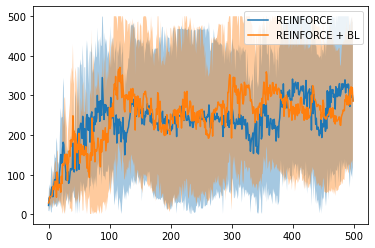

In [32]:
fig, ax = plt.subplots()
plot(ax, reinforce_rewards, label='REINFORCE')
plot(ax, reinforce_bl_rewards, label='REINFORCE + BL')
ax.legend()
plt.show()